In [1]:
%matplotlib inline
import os, glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helpers import check_blade_freqs, check_tower_freqs

# NREL-2.5-116
downscaled from the IEA-3.4-130 reference turbine

In [2]:
prefix = 'NREL-2.5-116'
rated_power = 2.5e6
D = 116.
rotor_area = np.pi/4 * D**2
print(f'specific power: {rated_power/rotor_area:g} W/m^2')

specific power: 236.556 W/m^2


In [3]:
aero_opt_steps = range(5)
aerostruct_opt_steps = range(7)
legendnames = [
    '0: IEA 3.4-130',
    '1: set power rating, rotor size, tower height',
    '2: twist opt',
    '3: twist+chord opt\nincrease minOmega, TSR',
    '4: twist+chord opt\n75% peak shaving',
    '5: blade mass opt',
    '6: tower mass opt',
]

In [4]:
figdir = 'figures'
os.makedirs(figdir,exist_ok=True)

## Reference Data

In [5]:
refdata = {
    'GE-2.5-120': '../../refdata/GE-2.5-120.csv',
    'GE-2.5-103': '../../refdata/GE-2.5-103.csv',
    'GE-2.5-100': '../../refdata/GE-2.5-100.csv',
}
markers = ['o','^','s']

In [6]:
ref = {}
for refname,refpath in refdata.items():
    print(refpath)
    df = pd.read_csv(refpath,index_col=0,comment='#')
    print(refname,df.columns)
    df = df.rename(columns={'power [kW]':'P','Cp':'Cp_aero','Ct':'Ct_aero'})
    df['P'] *= 1000
    if 'Ct_aero' in df.columns:
        df['T'] = df['Ct_aero'] * 0.5 * 1.225 * (df.index)**2 * rotor_area
    ref[refname] = df

../../refdata/GE-2.5-120.csv
GE-2.5-120 Index(['power [kW]', 'Cp', 'Ct'], dtype='object')
../../refdata/GE-2.5-103.csv
GE-2.5-103 Index(['power [kW]', 'Cp', 'Ct'], dtype='object')
../../refdata/GE-2.5-100.csv
GE-2.5-100 Index(['power [kW]', 'Cp'], dtype='object')


## Aerodynamics Optimization

outputs.0/refturb.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl
outputs.4/NREL-2_5-116-step4.pkl


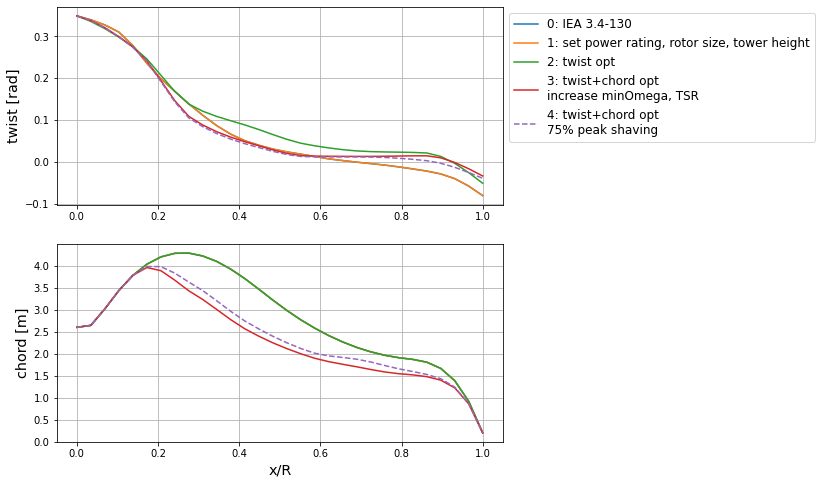

In [7]:
shape_quantities = ['twist','chord']

Nplot = len(shape_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aero_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    xs = turb['wt.wt_init.blade.outer_shape_bem.compute_blade_outer_shape_bem.s_default']['value']
    sty = dict(linestyle='--') if istep==4 else {}
    for i,qty in enumerate(shape_quantities):
        #df = turb[f'wt.wt_opt.blade.outer_shape_bem.compute_blade_outer_shape_bem.{qty}']
        df = turb[f'wt.ccblade.{qty}']
        ax[i].plot(xs,df['value'],label=legendnames[istep],**sty)
        ylabel = f'{qty} [{df["units"]}]'
        ax[i].set_ylabel(ylabel,fontsize='x-large')
    ax[-1].set_xlabel('x/R',fontsize='x-large')
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
for axi in ax:
    axi.grid()
    
fig.savefig(os.path.join(figdir,prefix+'_bladegeom.png'),bbox_inches='tight')

outputs.0/refturb.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl
outputs.4/NREL-2_5-116-step4.pkl


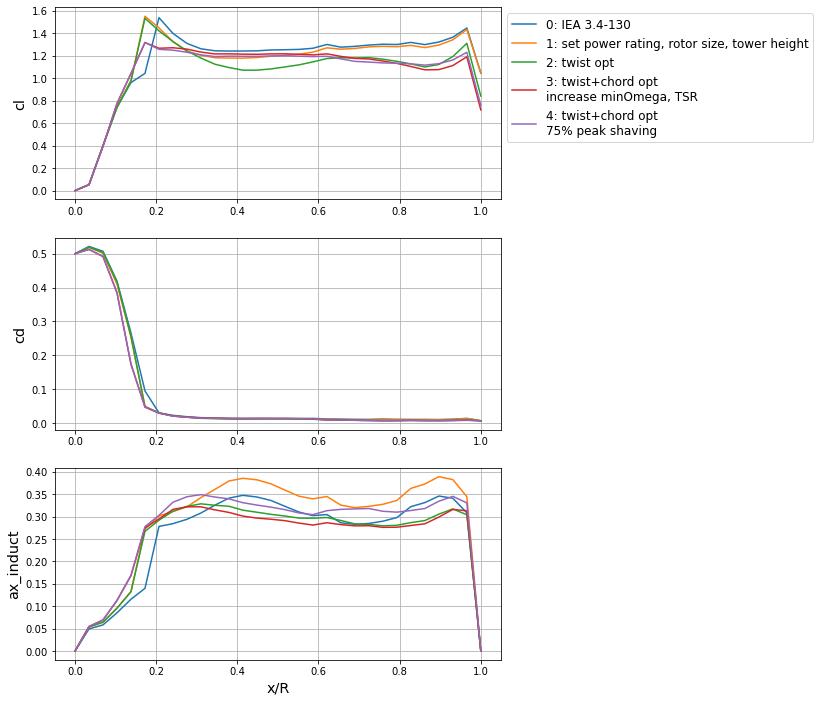

In [8]:
sectional_quantities = ['cl','cd','ax_induct']

Nplot = len(sectional_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aero_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    xs = turb['wt.wt_init.blade.outer_shape_bem.compute_blade_outer_shape_bem.s_default']['value']
    for i,qty in enumerate(sectional_quantities):
        df = turb[f'wt.rp.powercurve.compute_power_curve.{qty}_regII']
        ylabel = f'{qty} [{df["units"]}]'
        ax[i].plot(xs,df['value'],label=legendnames[istep])
        ax[i].set_ylabel(qty,fontsize='x-large')
    ax[-1].set_xlabel('x/R',fontsize='x-large')
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
for axi in ax:
    axi.grid()
    
fig.savefig(os.path.join(figdir,prefix+'_sectionalaero.png'),bbox_inches='tight')

outputs.0/refturb.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl
outputs.4/NREL-2_5-116-step4.pkl


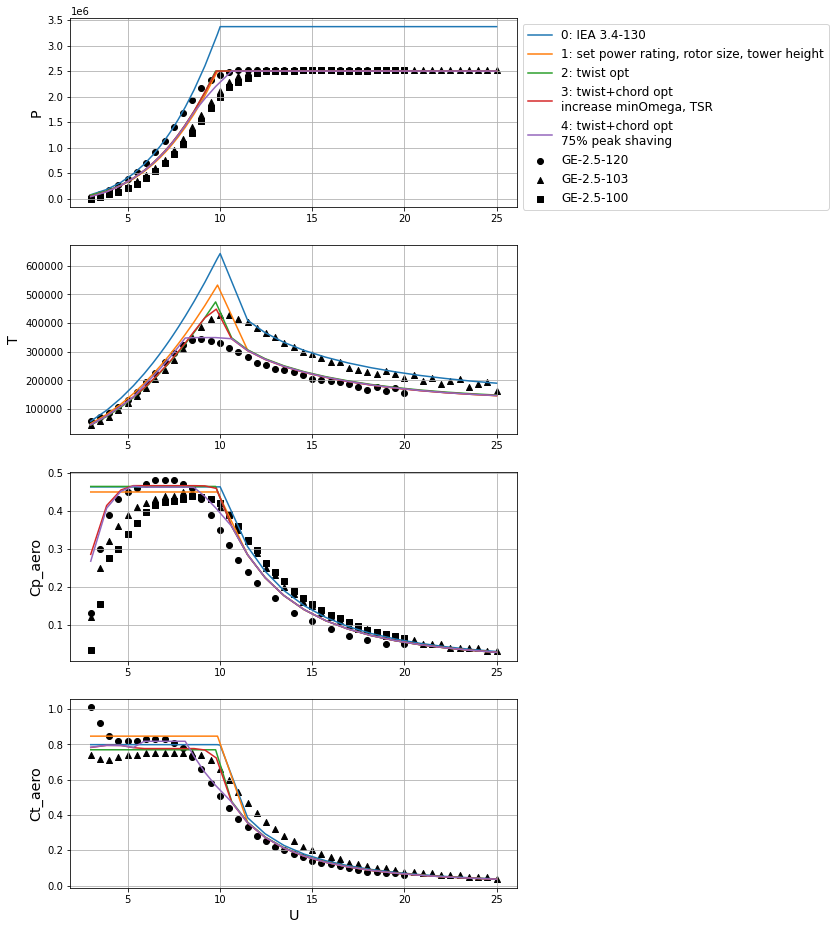

In [9]:
powercurve_quantities = ['P','T','Cp_aero','Ct_aero']

Nplot = len(powercurve_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aero_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    ws = turb['wt.rp.powercurve.compute_power_curve.V']['value']
    for i,qty in enumerate(powercurve_quantities):
        val = turb[f'wt.rp.powercurve.compute_power_curve.{qty}']['value']
        ax[i].plot(ws,val,label=legendnames[istep])
        ax[i].set_ylabel(qty,fontsize='x-large')
    ax[-1].set_xlabel('U',fontsize='x-large')
for axi in ax:
    axi.grid()

# add reference data
for i,qty in enumerate(powercurve_quantities):
    for iref,(refname,refvals) in enumerate(ref.items()):
        if qty in refvals.columns:
            ax[i].scatter(refvals.index,refvals[qty],color='k',marker=markers[iref],label=refname)
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
    
fig.savefig(os.path.join(figdir,prefix+'_aero.png'),bbox_inches='tight')

### - save aero design outputs

In [10]:
fpath = glob.glob(f'outputs.{aero_opt_steps[-1]}/*.pkl')[0]
print(fpath)
pkl = pickle.load(open(fpath,'rb'))
final = {keyval[0]: keyval[1] for keyval in pkl}

outputs.4/NREL-2_5-116-step4.pkl


In [11]:
powercurve_quantities = [
    # 'wt.rp.powercurve.compute_power_curve.*'
    'V',
    'Cp',
    'Ct_aero',
    'P',
    'P_aero',
    'T',
    'Q',
    'pitch',
    'Omega',
]
pc = {}
for name in powercurve_quantities:
    qty = final['wt.rp.powercurve.compute_power_curve.'+name]
    pc[name] = qty['value']
    print(f'{qty["desc"]} [{qty["units"]}] \t ({qty["prom_name"]})')

wind vector [m/s] 	 (rp.powercurve.V)
rotor electrical power coefficient [None] 	 (rp.powercurve.Cp)
rotor aerodynamic thrust coefficient [None] 	 (rp.powercurve.Ct_aero)
rotor electrical power [W] 	 (rp.powercurve.P)
rotor mechanical power [W] 	 (rp.powercurve.P_aero)
rotor aerodynamic thrust [N] 	 (rp.powercurve.T)
rotor aerodynamic torque [N*m] 	 (rp.powercurve.Q)
rotor pitch schedule [deg] 	 (rp.powercurve.pitch)
rotor rotational speed [rpm] 	 (rp.powercurve.Omega)


In [12]:
df = pd.DataFrame(
    data={
        'aerodynamic power [kW]': pc['P_aero'] / 1000.,
        'generator power [kW]': pc['P'] / 1000.,
        'rotor thrust [kN]': pc['T'] / 1000.,
        'rotor torque [kN-m]': pc['Q'] / 1000.,
        'rotor speed [RPM]': pc['Omega'],
        'blade pitch [deg]': pc['pitch'],
        'tip-speed ratio [-]': pc['Omega'] * np.pi/30 * (D/2) / pc['V'],
        'Cp [-]': pc['Cp'],
        'Ct [-]': pc['Ct_aero'],
    },
    index=pd.Index(pc['V'],name='wind speed [m/s]')
)

df.to_csv(os.path.join('..',prefix+'.csv'))

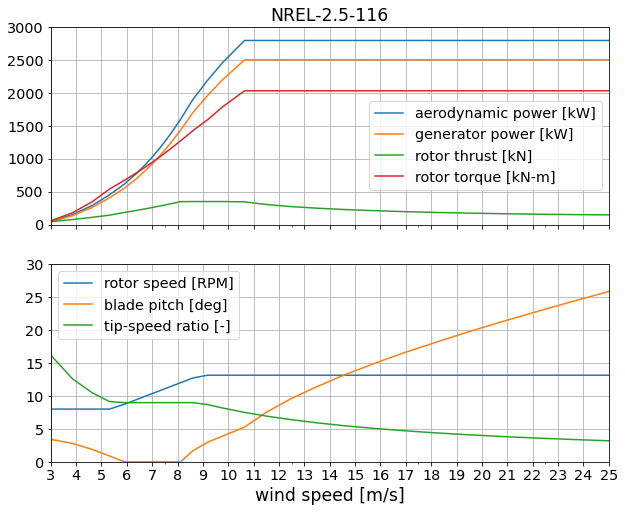

In [13]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(10,8))

df[['aerodynamic power [kW]','generator power [kW]','rotor thrust [kN]','rotor torque [kN-m]']].plot(ax=ax[0])
ax[0].set_ylim((0,1.2*rated_power/1000))

df[['rotor speed [RPM]','blade pitch [deg]','tip-speed ratio [-]']].plot(ax=ax[1])
ax[1].set_ylim((0,30))

for axi in ax:
    xticks = np.arange(3,26)
    axi.set_xticks(xticks)
    axi.set_xlim((xticks[0],xticks[-1]))
    axi.grid()
    axi.tick_params(labelsize='x-large')
    axi.legend(loc='best',fontsize='x-large')
axi.set_xlabel('wind speed [m/s]',fontsize='xx-large')
ax[0].legend(loc='center right',bbox_to_anchor=(1,0.4),fontsize='x-large') # need small adjustment in position
ax[0].set_title(prefix, fontsize='xx-large')

fig.savefig(os.path.join(figdir,prefix+'_design_overview.png'),bbox_inches='tight')

## Structural Optimization

In [14]:
for istep in aerostruct_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    try:
        blade_mass = turb['wt.re.precomp.blade_mass']['value'][0]
    except KeyError:
        print(f'Step {istep}: no precomp')
    else:
        print(f'Step {istep}: blade mass= {blade_mass:g} kg \t ({fpath})')

Step 0: blade mass= 14555.7 kg 	 (outputs.0/refturb.pkl)
Step 1: blade mass= 12988.2 kg 	 (outputs.1/NREL-2_5-116-step1.pkl)
Step 2: blade mass= 12983.9 kg 	 (outputs.2/NREL-2_5-116-step2.pkl)
Step 3: blade mass= 12446.8 kg 	 (outputs.3/NREL-2_5-116-step3.pkl)
Step 4: blade mass= 12557.9 kg 	 (outputs.4/NREL-2_5-116-step4.pkl)
Step 5: blade mass= 9978.38 kg 	 (outputs.5/NREL-2_5-116-step5.pkl)
Step 6: blade mass= 9978.38 kg 	 (outputs.6/NREL-2_5-116-step6.pkl)


In [15]:
for istep in aerostruct_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    tower_mass = turb['wt.towerse.geom.turb.tower_mass']['value'][0]
    print(f'Step {istep}: tower mass= {tower_mass:g} kg \t ({fpath})')

Step 0: tower mass= 620441 kg 	 (outputs.0/refturb.pkl)
Step 1: tower mass= 451230 kg 	 (outputs.1/NREL-2_5-116-step1.pkl)
Step 2: tower mass= 451230 kg 	 (outputs.2/NREL-2_5-116-step2.pkl)
Step 3: tower mass= 451230 kg 	 (outputs.3/NREL-2_5-116-step3.pkl)
Step 4: tower mass= 451230 kg 	 (outputs.4/NREL-2_5-116-step4.pkl)
Step 5: tower mass= 451230 kg 	 (outputs.5/NREL-2_5-116-step5.pkl)
Step 6: tower mass= 112799 kg 	 (outputs.6/NREL-2_5-116-step6.pkl)


outputs.0/refturb.pkl
outputs.1/NREL-2_5-116-step1.pkl
outputs.2/NREL-2_5-116-step2.pkl
outputs.3/NREL-2_5-116-step3.pkl
outputs.4/NREL-2_5-116-step4.pkl
outputs.5/NREL-2_5-116-step5.pkl
outputs.6/NREL-2_5-116-step6.pkl


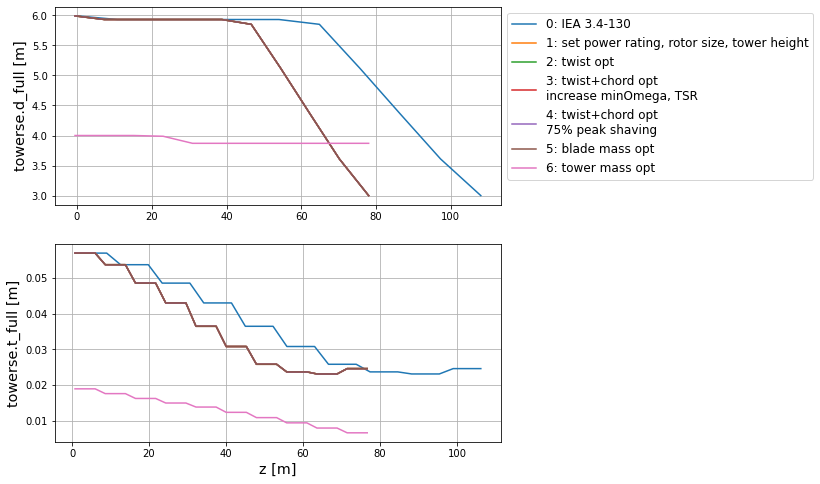

In [16]:
shape_quantities = ['d_full','t_full']

Nplot = len(shape_quantities)
fig,ax = plt.subplots(nrows=Nplot,figsize=(8,Nplot*4))
for istep in aerostruct_opt_steps:
    fpath = glob.glob(f'outputs.{istep}/*.pkl')[0]
    print(fpath)
    pkl = pickle.load(open(fpath,'rb'))
    turb = {keyval[0]: keyval[1] for keyval in pkl}
    zs = turb['wt.towerse.post.z_full']['value']
    zmid = 0.5 * (zs[1:] + zs[:-1])
    for i,qty in enumerate(shape_quantities):
        df = turb[f'wt.towerse.post.{qty}']
        if len(df['value']) == len(zs):
            ax[i].plot(zs,df['value'],label=legendnames[istep])
        elif len(df['value']) == len(zmid):
            ax[i].plot(zmid,df['value'],label=legendnames[istep])
        else:
            raise ValueError('Unexpected data length')
        ylabel = f'{df["prom_name"]} [{df["units"]}]'
        ax[i].set_ylabel(ylabel,fontsize='x-large')
    ax[-1].set_xlabel('z [m]',fontsize='x-large')
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1),fontsize='large')
for axi in ax:
    axi.grid()
    
fig.savefig(os.path.join(figdir,prefix+'_toweorpt.png'),bbox_inches='tight')

### - check natural frequencies

In [17]:
check_blade_freqs(aerostruct_opt_steps)

Step 0: outputs.0/refturb.pkl
  flap mode freqs [Hz]: [ 0.79110068  2.42318903  5.25856593  8.58140731 11.73122773]
  edge mode freqs [Hz]: [ 1.07275331  3.22770191  7.3415077  13.31158155 19.768443  ]
  3P, 6P freqs [Hz]: 0.588477224278313 1.176954448556626

Step 1: outputs.1/NREL-2_5-116-step1.pkl
  flap mode freqs [Hz]: [ 0.98417396  3.03074271  6.59069941 10.75969588 14.7099166 ]
  edge mode freqs [Hz]: [ 1.3402246   4.0437867   9.205825   16.6891734  24.77336676]
  3P, 6P freqs [Hz]: 0.6501525533841226 1.3003051067682452

Step 2: outputs.2/NREL-2_5-116-step2.pkl
  flap mode freqs [Hz]: [ 0.97309794  2.99171524  6.53350833 10.72357279 14.64091206]
  edge mode freqs [Hz]: [ 1.35946999  4.0843166   9.28654045 16.83045942 25.13327761]
  3P, 6P freqs [Hz]: 0.6433276857627864 1.2866553715255729

Step 3: outputs.3/NREL-2_5-116-step3.pkl
  flap mode freqs [Hz]: [ 0.83167422  2.51273858  5.27312869  8.66307312 12.21182813]
  edge mode freqs [Hz]: [ 1.14157356  3.59647126  7.97224898 14.307

In [18]:
check_tower_freqs(aerostruct_opt_steps)

Step 0: outputs.0/refturb.pkl
  1P, 3P freqs [Hz]: 0.19615907475943767 0.588477224278313
  tower fore-aft mode freqs [Hz]: [0.4039399  1.78449358 3.53197992]
  tower side-side mode freqs [Hz]: [0.40164606 1.62545453 3.31687751]

Step 1: outputs.1/NREL-2_5-116-step1.pkl
  1P, 3P freqs [Hz]: 0.21671751779470752 0.6501525533841226
  tower fore-aft mode freqs [Hz]: [0.70032442 2.74908237 5.79581705]
  tower side-side mode freqs [Hz]: [0.69472874 2.4794894  5.62666861]

Step 2: outputs.2/NREL-2_5-116-step2.pkl
  1P, 3P freqs [Hz]: 0.2144425619209288 0.6433276857627864
  tower fore-aft mode freqs [Hz]: [0.6999443  2.74945954 5.79569444]
  tower side-side mode freqs [Hz]: [0.69436058 2.4798776  5.62642999]

Step 3: outputs.3/NREL-2_5-116-step3.pkl
  1P, 3P freqs [Hz]: 0.21901896654724406 0.6570568996417322
  tower fore-aft mode freqs [Hz]: [0.70493152 2.80002768 5.83851295]
  tower side-side mode freqs [Hz]: [0.69972486 2.53677682 5.66242694]

Step 4: outputs.4/NREL-2_5-116-step4.pkl
  1P, 3P